In [1]:
# Imported Python files do not automatically reload after you modify them
# M1: Automatically Reload
%load_ext autoreload
%autoreload 2
# M2: Manual Reload
# import importlib
# import ksfdtw
# importlib.reload(ksfdtw)

# https://stackoverflow.com/questions/20309456/how-do-i-call-a-function-from-another-py-file
from ksfdtw import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, lb_keogh
from sklearn.metrics import accuracy_score
from tqdm import tqdm

/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
data = np.load("../data/gunpoint_preprocessed_with_cuts.npz", allow_pickle=True)

X_train = data["X_train"]
X_train_proc = data["X_train_proc"]
X_train_proc_noisy = data["X_train_proc_noisy"]
y_train = data["y_train"]
X_test = data["X_test"]
X_test_proc = data["X_test_proc"]
X_test_proc_noisy = data["X_test_proc_noisy"]
y_test = data["y_test"]

train_cutting_orig = data["train_cutting_orig"].tolist()
train_cutting_final = data["train_cutting_final"].tolist()
test_cutting_orig = data["test_cutting_orig"].tolist()
test_cutting_final = data["test_cutting_final"].tolist()


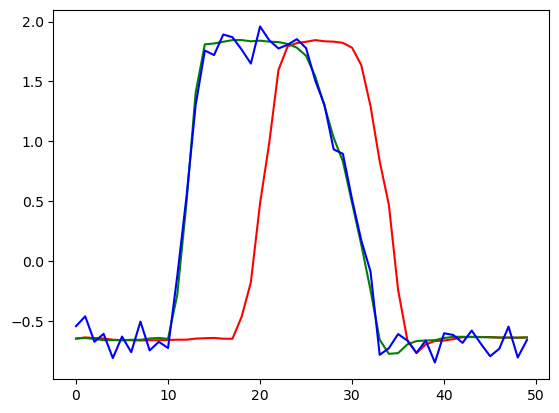

In [4]:
plt.plot(X_train[0], color="red")
plt.plot(X_train_proc[0], color="green")
plt.plot(X_train_proc_noisy[0], color="blue")
plt.show()

In [9]:
# 1-NN with LB_Keogh pruning and stats
class LBKeogh1NN:
    def __init__(self, lb_radius=5):
        self.lb_radius = lb_radius
        self.total_dtw_calls = 0
        self.total_pruned = 0

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        preds = []
        for x in tqdm(X_test, desc="Classifying"):
            min_dtw = float('inf')
            best_label = None
            for xt, label in zip(self.X_train, self.y_train):
                # Prune using LB_Keogh
                lb = lb_keogh(x, xt, radius=self.lb_radius)
                # if lb >= min_dtw:
                #     self.total_pruned += 1
                #     continue

                # dist = dtw(x, xt)
                # dist = euclidean_distance(x, xt)
                # dist = us_usdtw_p(x, xt, 2, 0.1, 50, distance_method="dtw")
                dist, _, _ = ps_distance_p(x, xt, 2, 0.1, 50, 3, distance_method="dtw")
                # distances = np.array([r[0] for r in results])

                self.total_dtw_calls += 1
                if dist < min_dtw:
                    min_dtw = dist
                    best_label = label
            preds.append(best_label)
        return np.array(preds)

# Run


In [14]:
ps_distance_p(X_train[0], X_test_proc[0], 2, 0.1, 50, 3, distance_method="dtw")

KeyboardInterrupt: 

In [13]:
ps_distance_p(X_train[0], X_test_proc_noisy[0], 2, 0.1, 50, 3, distance_method="dtw")

KeyboardInterrupt: 

In [12]:
len(X_train[0])

50

In [ ]:
model = LBKeogh1NN(lb_radius=5)
model.fit(X_train[:2], y_train[:2])
y_pred = model.predict(X_test[:2])



In [ ]:
# Results
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(f"DTW calls made: {model.total_dtw_calls}")
print(f"Candidates pruned by LB_Keogh: {model.total_pruned}")
total_candidates = len(X_test) * len(X_train)
print(f"Pruning ratio: {model.total_pruned / total_candidates:.2%}")
# Accuracy DTW 0.86 ED 0.6667 USDTW 0.7933
